# ViT test code

In [1]:
!nvidia-smi

Tue Jan 30 20:25:31 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA T600 Lap...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P0     8W /  35W |      9MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## classify
dataset : https://www.kaggle.com/jessicali9530/stanford-dogs-dataset

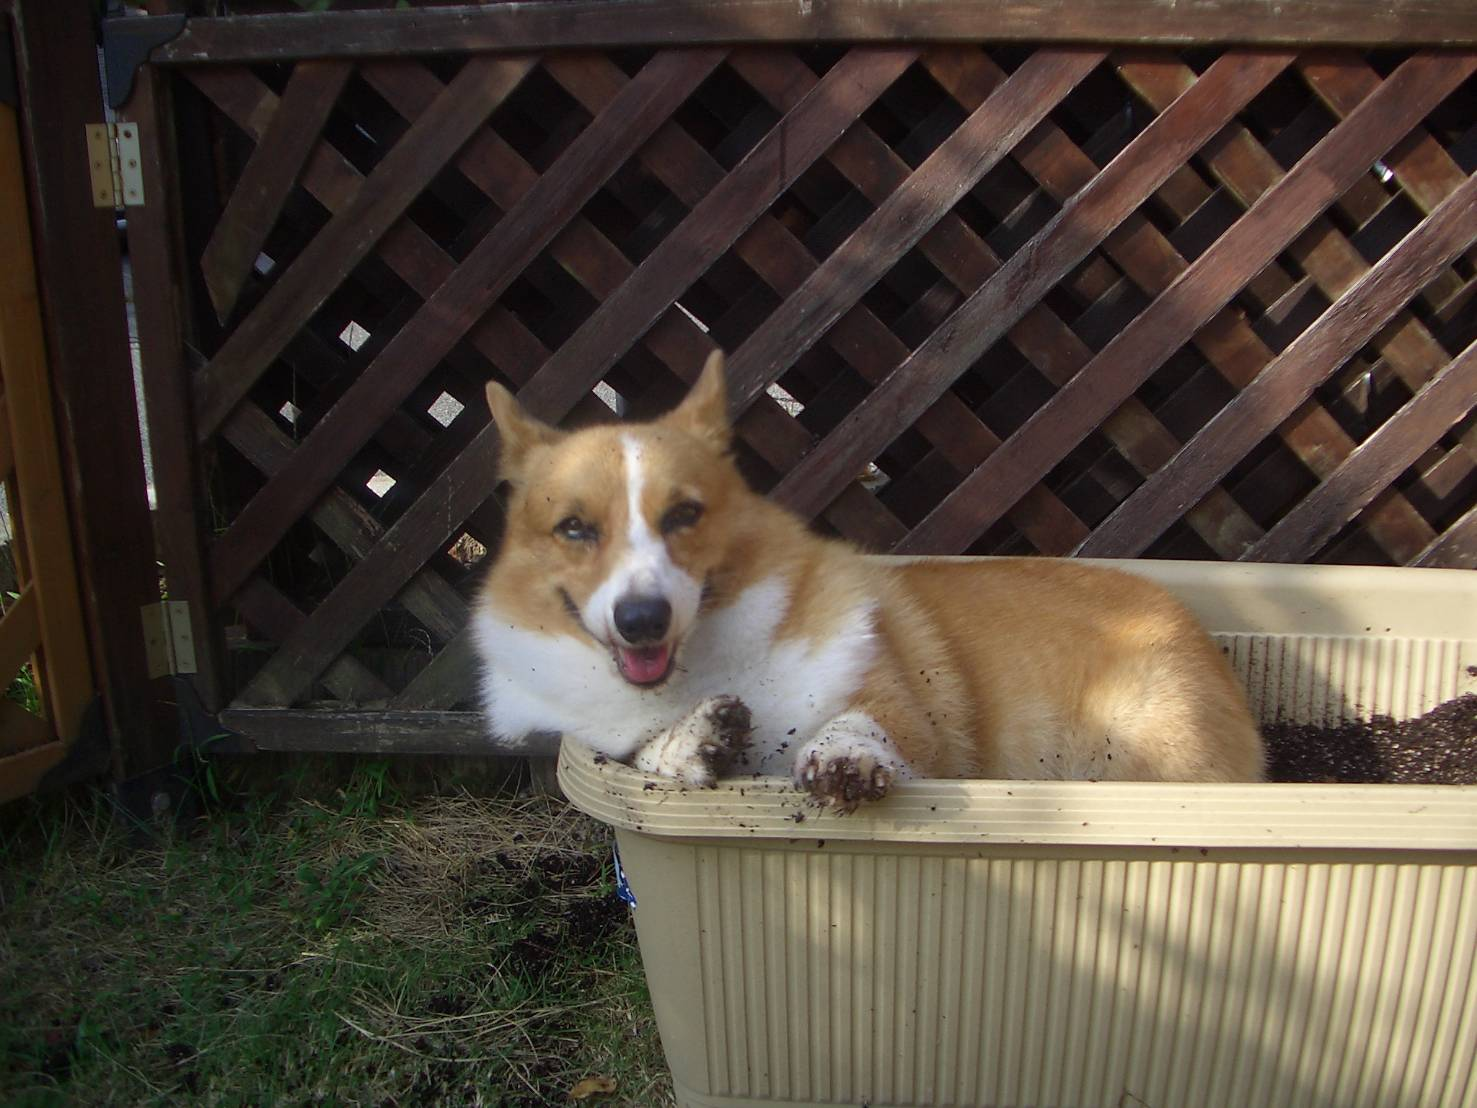

In [27]:
import os
from PIL import Image
import requests
import matplotlib.pyplot as plt

#url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
file_path = '/workspace/data/test_data/Pembroke_Welsh_Corgi.jpg'
image = Image.open(file_path)
image

## CPU process

In [31]:
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from transformers import ViTImageProcessor
import time

#CPUで実行
device = "cpu"
print(device)


# モデルと特徴抽出器をロード（SSLエラーの場合　プロキシと証明書を用意）
model_id = 'google/vit-base-patch16-224'
model = ViTForImageClassification.from_pretrained(model_id,device_map="auto").to(device)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

start = time.time()
# 画像をテンソルに変換
inputs = feature_extractor_gpu(images=image, return_tensors='pt').to(device)
# 推論
outputs = model(**inputs)
logits = outputs.logits # 1000クラスのスコアの配列
predicted_class_idx = logits.argmax(-1).item() # スコアが最大のインデックスを取り分類判定
print('class:', model.config.id2label[predicted_class_idx]) # インデックスをラベルに変換


fps = 1/(time.time() - start)
print("FPS:", fps)

cpu
class: Pembroke, Pembroke Welsh corgi
FPS: 8.859284042616109


## GPU process

In [32]:
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTImageProcessor
import time

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#モデルのロード
model_id = 'google/vit-base-patch16-224'
model_gpu = ViTForImageClassification.from_pretrained(model_id,device_map="auto").to(device)
feature_extractor_gpu = ViTFeatureExtractor.from_pretrained(model_id)

start = time.time()
# 画像をテンソルに変換、GPUに移動
inputs_gpu = feature_extractor_gpu(images=image, return_tensors='pt').to(device)

# 推論
outputs_gpu = model_gpu(**inputs_gpu)
logits_gpu = outputs_gpu.logits # 1000クラスのベクトル配列
predicted_class_idx_gpu = logits_gpu.argmax(-1).item() # スコアが最大のインデックスを取り分類判定
print('class:', model_gpu.config.id2label[predicted_class_idx_gpu]) # インデックスをラベルに変換

fps = 1/(time.time() - start)
print("FPS:", fps)

cuda
class: Pembroke, Pembroke Welsh corgi
FPS: 14.489698343167467
